In [418]:
import os, glob, pickle
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, tensor, optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.utils.data import RandomSampler, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [253]:
from apdf2latent_dataloader import *
from apdf2latent_model import *
from apdf2latent_trainer import *

%reload_ext autoreload
%autoreload 1
%aimport apdf2latent_dataloader, apdf2latent_model, apdf2latent_trainer

In [103]:
with open("descriptor.pkl", 'rb') as f:
    descriptor = pickle.load(f)

In [254]:
apdf_ds = Apdf2LatDataset(descriptor)
apdf_ds.cut_range(r=(1.6,2.5))

In [255]:
train_loader, test_loader, val_loader = get_Apdf2Lat_dataloaders(apdf_ds, batch_size=100)

In [381]:
N_epochs = 1000
learning_rate = 1e-4
device = torch.device('cuda')
model = Apdf2Lat(output_size=3).to(device)
loss_BCE = nn.BCELoss(reduction='mean').to(device)
solver: optim.Optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [382]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()
model.apply(weight_reset)

Apdf2Lat(
  (main): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(1, 4, kernel_size=(3, 1), stride=(2, 1))
    (2): ReLU()
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (4): Conv2d(4, 4, kernel_size=(3, 2), stride=(2, 1))
    (5): ReLU()
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): Conv2d(4, 4, kernel_size=(4, 2), stride=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.2, inplace=False)
    (14): Linear(in_features=16, out_features=8, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.2, inplace=False)
    (17): Linear(in_features=8, out_features=3, bias=True)
    (18): Softmax(dim=1)
  )
)

In [383]:
loss_train = np.zeros(N_epochs)
loss_val = np.zeros(N_epochs)

start = time.time() # start time
model = model.float()
loss_BCE = loss_BCE.float()
for epoch in range(N_epochs):
    
    model.train() # set to training mode
    loss_train_list = []
    for apdf_in, cn_in in train_loader:
        apdf_in = apdf_in.to(device)
        cn_in = cn_in.to(device)
        
        model.zero_grad()
        cn_pred = model(apdf_in.float())
        loss = loss_BCE(cn_pred, cn_in.float())
        loss_train_list.append(loss.detach().cpu().numpy())
        loss.backward()
        solver.step()
       
    model.eval()
    loss_val_list = []
    for apdf_in, cn_in in val_loader:
        apdf_in = apdf_in.to(device)
        cn_in = cn_in.to(device)
        cn_pred = model(apdf_in.float())
        loss = loss_BCE(cn_pred, cn_in.float())
        loss_val_list.append(loss.detach().cpu().numpy())
    
    loss_train[epoch] = np.array(loss_train_list).mean()
    loss_val[epoch] = np.array(loss_val_list).mean()
    
    
    if epoch%10 == 9:
        print('Epoch {:d}/{:d} | loss: {:.3f}/{:.3f}'
              .format(epoch+1, N_epochs, loss_train[epoch],loss_val[epoch]))    
    loss_train
    if epoch > 100 and loss_train[epoch]<loss_val[epoch]:
        break

print("Total time: {:.2f}".format((time.time()-start)/60.0))

Epoch 10/1000 | loss: 0.599/0.583
Epoch 20/1000 | loss: 0.558/0.534
Epoch 30/1000 | loss: 0.533/0.489
Epoch 40/1000 | loss: 0.500/0.451
Epoch 50/1000 | loss: 0.467/0.421
Epoch 60/1000 | loss: 0.456/0.397
Epoch 70/1000 | loss: 0.440/0.378
Epoch 80/1000 | loss: 0.430/0.361
Epoch 90/1000 | loss: 0.421/0.348
Epoch 100/1000 | loss: 0.412/0.339
Epoch 110/1000 | loss: 0.398/0.329
Epoch 120/1000 | loss: 0.399/0.319
Epoch 130/1000 | loss: 0.387/0.312
Epoch 140/1000 | loss: 0.381/0.306
Epoch 150/1000 | loss: 0.381/0.304
Epoch 160/1000 | loss: 0.372/0.298
Epoch 170/1000 | loss: 0.361/0.292
Epoch 180/1000 | loss: 0.366/0.288
Epoch 190/1000 | loss: 0.356/0.280
Epoch 200/1000 | loss: 0.360/0.278
Epoch 210/1000 | loss: 0.359/0.278
Epoch 220/1000 | loss: 0.342/0.270
Epoch 230/1000 | loss: 0.338/0.269
Epoch 240/1000 | loss: 0.330/0.265
Epoch 250/1000 | loss: 0.350/0.264
Epoch 260/1000 | loss: 0.340/0.260
Epoch 270/1000 | loss: 0.336/0.260
Epoch 280/1000 | loss: 0.309/0.258
Epoch 290/1000 | loss: 0.309/

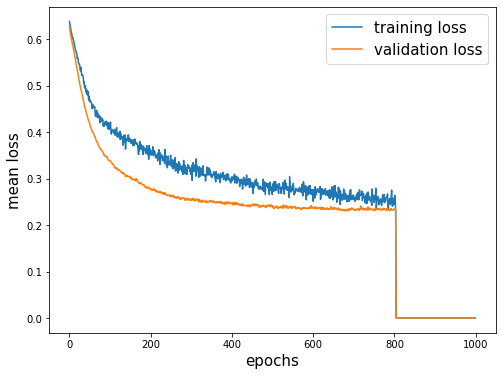

In [384]:
epochs = np.arange(N_epochs)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(epochs,loss_train,label='training loss')
ax.plot(epochs,loss_val,label='validation loss')
ax.set_xlabel('epochs',fontsize=15)
ax.set_ylabel('mean loss',fontsize=15)
ax.legend(fontsize=15)
# ax.set_xlim([-1,2000])
plt.show()

In [402]:
model.eval()
cn_pred_list = []
cn_true_list = []
for apdf_in, cn_in in test_loader:
    apdf_in = apdf_in.to(device)
    cn_in = cn_in.to(device)
    cn_pred = model(apdf_in.float())
    cn_true_list.append(cn_in.detach().cpu().numpy())
    cn_pred_list.append(cn_pred.detach().cpu().numpy())

cn_pred_test = np.vstack(cn_pred_list)
cn_true_test = np.vstack(cn_true_list)

In [417]:
GREEN = '#72d218'
RED = '#f4424b'
BLUE = '#72bdff'

y_true = cn_true_test[:,0]
y_pred = cn_pred_test[:,0]
def label_plot(ax, is_pr=True):
    x, y = (('recall', 'precision')
            if is_pr else
            ('false pos rate', 'true pos rate'))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    
def plot_pr_and_roc(y_true, y_pred, title):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = auc(r, p)
    print("F1={:.3f}, AUC={:.3f}".format(f1, auc))
    fig, axs = plt.subplots(2,1, figsize=(5,10))
    axs[0].plot(r, p, lw=4, color=GREEN)
    axs[0].set_title('PR')
    label_plot(axs[0], is_pr=True)

    axs[1].plot(fpr, tpr, lw=4, color=RED)
    axs[1].set_title('ROC')
    label_plot(axs[1], is_pr=False)

    fig.suptitle(title, fontsize=14)


i = 0
plot_pr_and_roc(cn_true_test[:,i], cn_pred_test[:,i], title='typical PR and ROC curves')



ValueError: Classification metrics can't handle a mix of binary and continuous targets

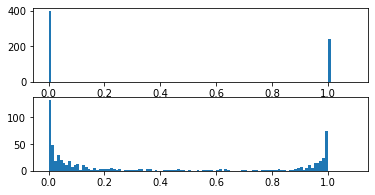

In [414]:
fig, axs = plt.subplots(2,1,figsize=(6,3))
i = 2
axs[0].hist(cn_true_test[:,i],bins=np.arange(0,1.1,0.01))
axs[1].hist(cn_pred_test[:,i],bins=np.arange(0,1.1,0.01))
plt.show()

In [ ]:
r = np.linspace(1.6,8,64)
r_selection = (r>=1.8)&(r<=3)
apdf_cut = apdf[:,:,r_selection][:,np.newaxis]
apdf_cut = tensor(apdf_cut, dtype=torch.float)
apdf_cut.shape

model = Apdf2Lat().to(device)
for p in model.parameters():
    print(p.shape,     np.prod(p.shape))

In [ ]:
result = model(apdf_cut.to(device))
result.shape

In [338]:
from apdf2latent_dataloader import *
apdf_plt = Apdf2LatDataset(descriptor)

In [385]:
apdf_plt.apdf.shape

(4262, 1, 64, 64)

In [388]:
apdf_ds.weight_per_cn

array([2.3200871 , 4.70419426, 2.80579329])

In [372]:
factor = 1 / r**2
i = np.random.randint(len(apdf_plt))

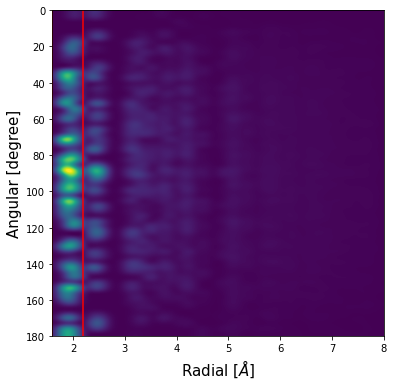

In [376]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(apdf_plt.apdf[i,0,:]*factor, extent=[1.6, 8.0, 180, 0], aspect=0.035, interpolation='spline36')
ax.set_xlabel('Radial [$\AA$]', fontsize=15)
ax.set_ylabel('Angular [degree]', fontsize=15)
ax.axvline(1.6,color='r')
ax.axvline(2.2,color='r')

plt.show()